In [455]:
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Dense

import matplotlib
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

import re
import requests
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)


In [417]:
# make sure all relevant files are in the same directory
!pwd

/Users/michaelliu/Desktop/tosubmit


Some cleaning was done in Microsoft Excel - the following:

1. Deleted rows with headers (because they were all merged, every file that was merged had its own header row)
2. Removed duplicates based on track_id - there were obviously many duplicates because playlists don't all have different songs

In [418]:
# uncleaned except excel cleaning; includes headers; includes all features that were scraped
playlists = pd.read_csv('merged_final.csv')
playlists.head()

,Unnamed: 0,album_id,album_name,year_released,album_release_date,track_artist_ids,track_id,track_duration_ms,track_explicit,track_name,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,audio_features_id,artist1_id,followers,artist_popularity,artist_genre1,artist_genre2,artist_genre3,album_label,album_popularity
0,0,1sXOM4wTy7TbTPdPz68YeF,Confrontation,4,1983,['2QsynagSdAqZj3U9HgDzjD'],1QQfbfMfyzNZhT5fg3RpuS,257440,False,Buffalo Soldier,61,0.932,0.462,9.0,-8.664,1.0,0.2840,0.1370,0.000008,0.0653,0.749,124.122,1QQfbfMfyzNZhT5fg3RpuS,2QsynagSdAqZj3U9HgDzjD,5408846.0,79.0,reggae,roots reggae,NaN,Island Records,54.0
1,1,3q8y9MBuOdOzwJb8QJfwBG,Exodus (Deluxe Edition),5,1/1/77,['2QsynagSdAqZj3U9HgDzjD'],4OsZ1vrenrtSbqLJxOceKl,172933,False,One Love / People Get Ready,57,0.725,0.523,10.0,-9.593,1.0,0.3240,0.0783,0.000000,0.0665,0.950,76.292,4OsZ1vrenrtSbqLJxOceKl,2QsynagSdAqZj3U9HgDzjD,5408846.0,79.0,reggae,roots reggae,NaN,Island Records,61.0
2,2,2sjqgdbvLYmvpC3CL8kkyK,Kaya,4,1978,['2QsynagSdAqZj3U9HgDzjD'],6M5cQCyieE1Q8YQydVLzxL,232200,False,Is This Love,58,0.775,0.553,6.0,-8.371,0.0,0.1020,0.1060,0.000000,0.0518,0.753,122.232,6M5cQCyieE1Q8YQydVLzxL,2QsynagSdAqZj3U9HgDzjD,5408846.0,79.0,reggae,roots reggae,NaN,Island Records,54.0
3,3,24qLt9W28msLjUqsucGt1B,Live!,5,1/1/75,['2QsynagSdAqZj3U9HgDzjD'],2mKsPUojh602HvSeNt04CB,427800,False,"No Woman, No Cry - Live At The Lyceum, London/...",53,0.649,0.673,1.0,-9.350,1.0,0.0638,0.2490,0.035100,0.7260,0.587,78.535,2mKsPUojh602HvSeNt04CB,2QsynagSdAqZj3U9HgDzjD,5408846.0,79.0,reggae,roots reggae,NaN,Island Records,46.0
4,4,3m89meycBx0T7hYBhj2kkq,This Is The Life,5,9/25/09,['3Je8tRazTtqZxGkbeJDGL8'],3QCQkTBqwzZ37aQBmmCu2L,227173,False,Genuine Love,44,0.635,0.544,7.0,-8.197,1.0,0.0287,0.2730,0.000028,0.1460,0.352,136.919,3QCQkTBqwzZ37aQBmmCu2L,3Je8tRazTtqZxGkbeJDGL8,81347.0,53.0,polynesian pop,NaN,NaN,Go Aloha Entertainment,57.0


In [419]:
# Converting album_release_date to YYYY format
import re

bad_indices = [] # will drop tracks with year formats that are not one of the following:

lst_4_years = [] # YYYY formats
lst_2_slash = [] # MM/DD/YY formats
lst_2_hyphen = [] # YYYY-MM formats

lst_year_release = [] # to store years converted to standardized format YYYY

for i, date in enumerate(playlists.album_release_date):

    if len(date)==4: # keep YYYY as is
        lst_4_years.append(date)
        lst_year_release.append(date)
        
    elif re.findall(r"(.){1,2}[/](.){1,2}[/](.){1,2}",date): # convert MM/DD/YY
        lst_2_slash.append(date)
        
        if int(date[-2:]) < 19: # for years 2000 to 2018
            lst_year_release.append("20"+(date[-2:]))
        else:
            lst_year_release.append("19"+(date[-2:])) # for years 1939 (oldest year) to 1999
        
    elif re.findall(r"(.){4}-(.){2}",date): # convert YYYY-MM
        lst_2_hyphen.append(date)
        lst_year_release.append(date[:4])
        
    else:
        bad_indices.append((i, date))
        
print(len(bad_indices)) # there are no bad indices :) that means all release dates were in one of the above 3 formats
playlists["release_year"] = lst_year_release

0


In [420]:
# how did we know there wouldn't be a problem where e.g. MM/DD/(19)18 and MM/DD/(20)18 would be mistaken as the same?
print(sorted(set(lst_year_release)))
# as you can see, there is no years before 1939 and therefore this problem simply wouldn't arise.

['1939', '1942', '1945', '1947', '1948', '1949', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']


In [421]:
# drop non-quant and garbage columns
X_database = playlists.drop(['Unnamed: 0','album_id', 'album_name', 'album_release_date', 'track_artist_ids', 'track_id', 'track_name', 'audio_features_id', 'artist1_id', 'artist_genre1', 'artist_genre2', 'artist_genre3', 'album_label','year_released'], axis=1)
X_database.shape

(19167, 18)

In [422]:
X_database = X_database.dropna(axis=0)
X_database.shape
# looks like 3 rows had NaNs - makes sense, if you look at our data scraping mechanism

(19164, 18)

In [423]:
# make a copy because right after on we'll be temporarily deleting some cols we want to add back
X_database_main = X_database.copy() 

# delete binary values which will not be standardized
del X_database["track_explicit"]
del X_database["mode"]

# standardize all quantitative columns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_database)
X_database_scaled = scaler.transform(X_database)
X_database_scaled = pd.DataFrame(X_database_scaled)
X_database_scaled.columns = X_database.columns

# add back binary columns
X_database_scaled["track_explicit"] = X_database_main["track_explicit"]
X_database_scaled["mode"] = X_database_main["mode"]

In [424]:
X_database_scaled.head()

,track_duration_ms,track_popularity,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,followers,artist_popularity,album_popularity,release_year,track_explicit,mode
0,0.299349,0.974197,2.100562,-0.828570,1.056385,-0.295193,1.587166,-0.406791,-0.361834,-0.773386,1.072156,0.078649,0.897137,1.019174,0.337712,-2.177343,False,1.0
1,-0.832847,0.766546,0.821219,-0.547890,1.335508,-0.535852,1.920664,-0.605799,-0.361869,-0.766322,1.893511,-1.577604,0.897137,1.019174,0.696525,-2.701878,False,1.0
2,-0.038808,0.818459,1.130239,-0.409850,0.219014,-0.219291,0.069751,-0.511889,-0.361869,-0.852856,1.088501,0.013202,0.897137,1.019174,0.337712,-2.614456,False,0.0
3,2.581774,0.558894,0.351509,0.142308,-1.176604,-0.472902,-0.248740,-0.027081,-0.208047,3.115925,0.410168,-1.499934,0.897137,1.019174,-0.072360,-2.876723,False,1.0
4,-0.106158,0.091679,0.264984,-0.451262,0.498137,-0.174216,-0.541384,0.054285,-0.361746,-0.298333,-0.550123,0.521782,-0.468829,-0.444046,0.491489,0.095643,False,1.0


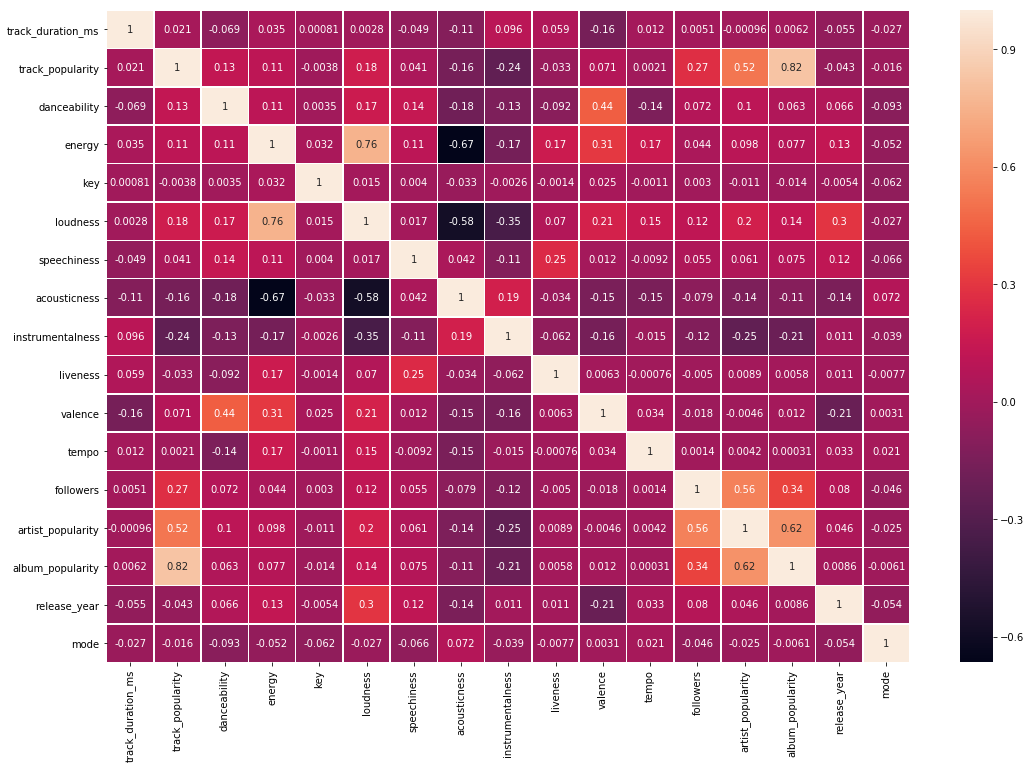

In [425]:
# correlation plot between all predictors
import seaborn as sns

plt.subplots(figsize=(18, 12))
corr = X_database_scaled.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, linewidths=.5,annot=True)

Based on the correlation plot we are going to drop one of all pairs of predictors that have higher than 0.75 correlation in magnitude. This is to ensure that when we fit a regression model, the weights/coefficients of two nearly collinear predictors aren't arbitrarily distributed, which would ruin interpretability for both those predictors. 

The pairs that meet that criteria are Loudness and Energy, and Album Popularity and Track Popularity. These high correlations make sense and the both predictors in each pair should probably not go into the same model from a logical standpoint as well. 

We decide which one to drop based on the one that has the next highest correlation with a different predictor, i.e. we drop energy over loudness because energy has a stronger correlation with acousticness, and we drop album over track popularity because album pop has a stronger correlation with artist popularity.

In [426]:
del X_database_scaled['energy']
del X_database_scaled['album_popularity']

DO NOT RUN THE CELL BELOW.

In the cell below we originally generate 20 random track IDs to give to our 3 subjects, Helen, Dhruv, and Isabelle. We printed out the corresponding Spotify open link and told them to listen to them fully.
They each returned ratings from 1-10, decimals allowed, for each song.

We have commented out the below code because running it again generates new track IDs (we accidentally did this ourselves), and we want to keep track of songs we actually gave them.

In [427]:
# indices = np.arange(X_database_scaled.shape[0])

# random_indices = np.random.choice(indices, size=20, replace=False)
# random_indices2 = np.random.choice(indices, size=20, replace=False)
# random_indices3 = np.random.choice(indices, size=20, replace=False)

# # RANDOM SONGS FOR HELEN
# helen_X = X_database_scaled.loc[random_indices]
# for id in helen.track_id:
#     print('https://open.spotify.com/track/{}'.format(id))

# # RANDOM SONGS FOR DHRUV
# dhruv_X = X_database_scaled.loc[random_indices2]
# for id in dhruv.track_id:
#     print('https://open.spotify.com/track/{}'.format(id))

# # RANDOM SONGS FOR ISABELLE
# isabelle_X = X_database_scaled.loc[random_indices3]
# for id in isabelle.track_id:
#     print('https://open.spotify.com/track/{}'.format(id))

In [428]:
# here you can see that we accidentally generated new random track IDs, so we had to go back to the lists we provided
# for our subjects and retrieve the right ones...

helen_links = ['https://open.spotify.com/track/6OG1S805gIrH5nAQbEOPY3',
'https://open.spotify.com/track/0SGkqnVQo9KPytSri1H6cF',
'https://open.spotify.com/track/3Bp478Itxv8gxqqEcf8HRL',
'https://open.spotify.com/track/7iaw359G2XT14uTfV9feip',
'https://open.spotify.com/track/5qmZHOqnuKopAfKv8W61oN',
'https://open.spotify.com/track/3lBRNqXjPp2j3JMTCXDTNO',
'https://open.spotify.com/track/4uQ7wYsuL0DryknoDc11Hk',
'https://open.spotify.com/track/16qYlQ6koFxYVbiJbGHblz',
'https://open.spotify.com/track/4y5Cc7AOL8CIdtLWdcuGMg',
'https://open.spotify.com/track/7DDRPKLKFIvDbNSQmnz19Y',
'https://open.spotify.com/track/6fZersDfjZ7CMyLe0jvixb',
'https://open.spotify.com/track/22eADXu8DfOAUEDw4vU8qy',
'https://open.spotify.com/track/0lAveUGBd27UoLnhbnSzgG',
'https://open.spotify.com/track/0jn2XqaHliEpWd04ZykIHy',
'https://open.spotify.com/track/6Z8R6UsFuGXGtiIxiD8ISb',
'https://open.spotify.com/track/1XGwjdHXHNu3842f75eg3T',
'https://open.spotify.com/track/6EpRaXYhGOB3fj4V2uDkMJ',
'https://open.spotify.com/track/2lH6RlA7NA2CcTfyEsONTc',
'https://open.spotify.com/track/1SayqEg8HKK2IeIEWjdYxY',
'https://open.spotify.com/track/2fQrGHiQOvpL9UgPvtYy6G']

dhruv_links = ['https://open.spotify.com/track/5xS9hkTGfxqXyxX6wWWTt4',
'https://open.spotify.com/track/56ZDcszhe1eCeghso93fXP',
'https://open.spotify.com/track/60geMByGdlcGGMR5R5ZjHE',
'https://open.spotify.com/track/4gHSezW5CHZCvjAUjF2pd5',
'https://open.spotify.com/track/2eW8aJXH9OSqJuw1UcPEj6',
'https://open.spotify.com/track/2IO7yf562c1zLzpanal1DT',
'https://open.spotify.com/track/2SJMm1mWgcy3pj2gMfwRiQ',
'https://open.spotify.com/track/4Sfa7hdVkqlM8UW5LsSY3F',
'https://open.spotify.com/track/4JuZQeSRYJfLCqBgBIxxrR',
'https://open.spotify.com/track/5ybydtBlJJL82AprlvN7Lg',
'https://open.spotify.com/track/5R0b6aGJH9J6BW4eNUgYDd',
'https://open.spotify.com/track/6Yzh272O4hwZHjrnXYhL8a',
'https://open.spotify.com/track/1UE2mIj6uy9Tip2cvQx5xu',
'https://open.spotify.com/track/79nEEoEPY2w8EXj9hjn5oc',
'https://open.spotify.com/track/3JDNTieVelwwVvIIpPqAH3',
'https://open.spotify.com/track/26nxjX1zXkT8oVwO9RPUMf',
'https://open.spotify.com/track/4qdgv45EPcQqpQ08tF34f8',
'https://open.spotify.com/track/2pA4ip3VIEVcIa3qE02oAX',
'https://open.spotify.com/track/1KDYN3odJHnj9pqGHN3FVs',
'https://open.spotify.com/track/5C4PHNJIGuYYcMDsvKmLSV']

isabelle_links = ['https://open.spotify.com/track/0UdWlvyc1Hc97LRX3zAOwC',
'https://open.spotify.com/track/7cb98TMQPLbkE86up3uLz6',
'https://open.spotify.com/track/00xR9dHhuaNznqB4FSzOlr',
'https://open.spotify.com/track/7cjZxxdwK4NLtXyKCTQnNR',
'https://open.spotify.com/track/4MimthDKiYVMCqDBJEiw1U',
'https://open.spotify.com/track/6IEMLVQMHWuqNX50gGdsYB',
'https://open.spotify.com/track/5YzA563GXTuwQaRq24z1k5',
'https://open.spotify.com/track/78WVLOP9pN0G3gRLFy1rAa',
'https://open.spotify.com/track/4Tjh34RS4ACZ6f6srlDBg8',
'https://open.spotify.com/track/24lORMRGMv9sXpZJdN1PVm',
'https://open.spotify.com/track/1oh8AROxt4IUEH42CEFRb9',
'https://open.spotify.com/track/4SKlwyLMGQdzul5S5TvCh5',
'https://open.spotify.com/track/6ngavex4sZrVTif1wwRof0',
'https://open.spotify.com/track/6L2Eoo8Dzx60hARXy7TCic',
'https://open.spotify.com/track/3a1lNhkSLSkpJE4MSHpDu9',
'https://open.spotify.com/track/0aPrTlWUf2nmDkC9gcP5kZ',
'https://open.spotify.com/track/0BBOLOV5JntPL3341swIre',
'https://open.spotify.com/track/2qFIJT5hjqaNFA1GKwl9me',
'https://open.spotify.com/track/7i9HsRBt4punMJWoCoSeu6',
'https://open.spotify.com/track/2rqUblDWJKlMVwh9uJc0Vv']

helen_ids = [helen_link[31:] for helen_link in helen_links]
dhruv_ids = [dhruv_link[31:] for dhruv_link in dhruv_links]
isabelle_ids = [isabelle_link[31:] for isabelle_link in isabelle_links]

In [429]:
# we need to get the indices from playlists rather than X_database_scaled because it has information like IDs 
# that aren't being used as predictors, but are obviously crucial for referencing.

helen_indices = [] # the indices from 'playlists' that correspond to their assigned random tracks
for ID in helen_ids:
    helen_indices.append(playlists.track_id[playlists.track_id == ID].index[0]) 
    
dhruv_indices = []
for ID in dhruv_ids:
    dhruv_indices.append(playlists.track_id[playlists.track_id == ID].index[0])
    
isabelle_indices = []
for ID in isabelle_ids:
    isabelle_indices.append(playlists.track_id[playlists.track_id == ID].index[0])

From here on, we are demoing our models with Helen's data. If you are interested in seeing the results from Dhruv and Isabelle as well, see our "Human results" section on the website.

In [430]:
# These 20 ratings were provided by Helen herself. They are arranged in the same order as the tracks we gave her.
helen_y = [8, 7.5, 3, 5, 5, 7.5, 7, 6, 9, 6, 4, 4, 5, 6, 8, 4, 6, 6.5, 5, 8.5]

In [431]:
# a simple linear regression model, no higher orders, trained on Helen's 20 songs and ratings 
simple_LR_model = LinearRegression().fit(helen_X, helen_y)

# predictors and their coefficients (based on Helen's preferences)
weights = zip(helen_X.columns.values, simple_LR_model.coef_)
for weight in weights:
    print(weight)

('track_duration_ms', 0.515496265348243)
('track_popularity', 1.4077916392670764)
('danceability', -0.33696372721600854)
('key', 0.8184112526498223)
('loudness', -0.7879796592182295)
('speechiness', -0.13193310307488265)
('acousticness', -0.6005089507258942)
('instrumentalness', -0.9292250036317006)
('liveness', -1.180497354425426)
('valence', 0.46091770635186124)
('tempo', 0.49193055156456655)
('followers', 1.335690730390116)
('artist_popularity', -1.72994622316518)
('release_year', 1.6926095990110246)
('track_explicit', 0.35192575148128913)
('mode', 0.7837927968302959)


In [437]:
# need to drop nan's again - a few were generated during scaling
X_database_scaled = X_database_scaled.dropna(axis=0)
X_database_scaled.shape

(19161, 16)

In [439]:
preds_LR = est_model.predict(X_database_scaled) # a list of predictions of Helen's ratings of all songs in the database

In [440]:
database_full = X_database_scaled.copy() # df to hold both predictors and predicted ratings
database_full['predicted_ratings'] = preds

In [443]:
database_sorted = database.sort_values(by=['predicted_ratings']) # sort from worst to best ratings
top5_lr = database_sorted[database_sorted.shape[0] - 5:] # top 5 ratings (this number can be increased to get more songs)
top5_lr

,track_duration_ms,track_popularity,danceability,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,followers,artist_popularity,release_year,track_explicit,mode,predicted_ratings
14542,0.608741,1.597151,0.153737,1.056385,0.490770,-0.556391,0.566215,-0.361869,-0.410179,-0.999621,0.627743,7.210965,1.638228,0.795023,False,1.0,17.049593
2683,0.379199,2.375843,0.042489,0.777261,0.314096,-0.587240,-0.318644,-0.361869,-0.533799,-1.302010,-0.928054,7.193259,1.638228,0.795023,False,1.0,17.728763
14538,-0.102769,1.545238,0.295886,0.777261,0.486366,-0.085326,-0.579694,-0.361869,-0.858154,1.746402,-1.240986,7.210963,1.638228,0.795023,False,1.0,17.838077
7413,0.880807,1.700977,-0.068758,1.335508,-3.364954,-0.449672,1.023900,-0.361869,-0.735123,-1.032311,1.045287,7.194917,1.638228,0.445333,False,0.0,19.565538
6663,37.207660,-1.413793,-0.859848,-1.176604,0.198300,-0.220392,-0.859493,-0.289997,0.537572,-1.367392,1.805127,-0.483023,-0.950545,0.620178,False,1.0,24.363518


In [446]:
# print spotify open links for Helen to listen to - she *should* like them.
indices = [index for index in top5_lr.index]
top_ids = playlists.loc[indices].track_id.values
for track_id in top_ids:
    print('https://open.spotify.com/track/{}'.format(track_id))

https://open.spotify.com/track/2RttW7RAu5nOAfq6YFvApB
https://open.spotify.com/track/0tgVpDi06FyKpA1z0VMD4v
https://open.spotify.com/track/35QZaWQRkmnAVqBF1TLCxQ
https://open.spotify.com/track/3B7udSGy2PfgoCniMSb523
https://open.spotify.com/track/7hqowhuDmklJV3DwV9vF5p


Helen's ratings: 10, 9, 9, 7, 5.5
These turn out to be really good! The top 3 songs chosen were actually from the same Ed Sheeran album, which Helen claims "she really loves." 

We will now fit a couple other different models to see if we get similar results from Helen.

In [447]:
from sklearn.ensemble import RandomForestRegressor

est_rf = RandomForestRegressor(random_state=15).fit(helen_X, helen_y)
preds_rf = est_rf.predict(X_database_scaled)

database_rf = X_database_scaled.copy()
database_rf['predicted_ratings'] = preds_rf

database_rf_sorted = database_rf.sort_values(by=['predicted_ratings'])
top5_rf = database_rf_sorted[database_rf_sorted.shape[0]-5:]
top5_rf

,track_duration_ms,track_popularity,danceability,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,followers,artist_popularity,release_year,track_explicit,mode,predicted_ratings
7114,-0.193873,0.714633,1.779181,1.614632,-1.840435,0.069751,-0.807859,-0.361727,-0.821656,1.501222,-0.162396,-0.464709,-0.500323,-1.565385,False,1.0,8.55
4566,0.973693,0.455069,2.069660,1.335508,-0.036400,-0.277087,-0.824132,-0.361857,-0.925850,1.926202,-0.223930,-0.440344,-0.612879,-1.827653,False,0.0,8.60
1856,-0.268712,0.403156,1.698836,1.335508,0.038725,0.178138,-0.790229,-0.361869,-0.868750,0.769766,0.102473,-0.472750,-0.500323,0.270488,False,0.0,8.60
15224,1.141606,0.506982,1.816263,1.335508,-0.440262,-0.168700,-0.821081,-0.361850,-0.866984,0.933220,0.095270,-0.472724,-0.500323,-1.652808,False,0.0,8.60
12022,0.690909,0.870371,1.006631,0.219014,-0.885312,-0.262080,-0.768871,-0.361869,-0.839316,1.129364,0.159089,-0.458368,-0.218935,-2.614456,False,0.0,8.65


In [449]:
indices = [index for index in top5_rf.index]
top_ids = playlists.loc[indices].track_id.values
for track_id in top_ids:
    print('https://open.spotify.com/track/{}'.format(track_id))

https://open.spotify.com/track/2RCOWNCxDIphjhqTtkwtwR
https://open.spotify.com/track/1YCsTFttuHAzgfEWKdOb9K
https://open.spotify.com/track/7BwwjDFcpn72BrxCCRqs7d
https://open.spotify.com/track/5mNV8Mz59bzyuQ53gTw0c0
https://open.spotify.com/track/58r4JuwHhXLAkttkaUZfLw


Helen's ratings: 6, 7, 4.5, 3.5, 5

RandomForest regression is significantly worse, barely averaging above a 5. 

In [450]:
model = Sequential([
    Dense(200, input_shape=(16,), activation='relu'), #Dense = fully connected
    Dense(150, activation='relu'), 
    Dense(100, activation='relu'), 
    Dense(1, activation='relu') #using relu as activation produces far better results than softmax
])

In [451]:
model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 200)               3400      
_________________________________________________________________
dense_22 (Dense)             (None, 150)               30150     
_________________________________________________________________
dense_23 (Dense)             (None, 100)               15100     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 101       
Total params: 48,751
Trainable params: 48,751
Non-trainable params: 0
_________________________________________________________________


In [452]:
model.fit(helen_X, helen_y, epochs=50, batch_size=32, validation_split = .2) 

Train on 16 samples, validate on 4 samples
Epoch 1/50
16/16 [==============================] - 0s 23ms/step - loss: 5.8222 - val_loss: 6.1290
Epoch 2/50
16/16 [==============================] - 0s 138us/step - loss: 5.5203 - val_loss: 5.8738
Epoch 3/50
16/16 [==============================] - 0s 154us/step - loss: 5.2033 - val_loss: 5.6240
Epoch 4/50
16/16 [==============================] - 0s 142us/step - loss: 4.9081 - val_loss: 5.3322
Epoch 5/50
16/16 [==============================] - 0s 154us/step - loss: 4.5704 - val_loss: 5.0218
Epoch 6/50
16/16 [==============================] - 0s 137us/step - loss: 4.2201 - val_loss: 4.6868
Epoch 7/50
16/16 [==============================] - 0s 131us/step - loss: 3.8951 - val_loss: 4.3265
Epoch 8/50
16/16 [==============================] - 0s 135us/step - loss: 3.5580 - val_loss: 3.9308
Epoch 9/50
16/16 [==============================] - 0s 145us/step - loss: 3.1827 - val_loss: 3.4942
Epoch 10/50
16/16 [==============================] - 0s 13

In [453]:
preds_nn = model.predict(X_database_scaled)

database_nn = X_database_scaled.copy()
database_nn['predicted_ratings'] = preds_nn

database_nn_sorted = database_nn.sort_values(by=['predicted_ratings'])
top5_nn = database_nn_sorted[database_nn_sorted.shape[0]-5:]
top5_nn

,track_duration_ms,track_popularity,danceability,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,followers,artist_popularity,release_year,track_explicit,mode,predicted_ratings
7976,11.743079,-0.842752,0.419494,0.498137,-0.383788,-0.462178,-0.632582,2.552429,-0.662128,0.630830,-1.032007,-0.463711,-0.781712,-3.226414,False,1.0,18.094307
15875,12.897971,-0.894665,0.153737,1.335508,-1.886029,-0.352124,-0.454254,3.503410,0.855451,-1.782973,1.494030,-0.460260,-0.837989,-0.866005,False,1.0,19.430754
16042,15.166101,0.143592,-1.601496,-0.897480,-2.093529,-0.475518,-0.515279,3.459586,-0.398406,-1.526759,-1.390994,-0.415280,-0.500323,-2.964146,False,1.0,19.783613
8787,15.250948,-0.583188,-1.552053,-0.339233,-0.172661,-0.167033,0.901850,1.246473,1.296950,-0.770785,-0.423421,-0.361190,0.175009,-3.226414,True,0.0,21.579975
6663,37.207660,-1.413793,-0.859848,-1.176604,0.198300,-0.220392,-0.859493,-0.289997,0.537572,-1.367392,1.805127,-0.483023,-0.950545,0.620178,False,1.0,64.406158


In [454]:
indices = [index for index in top5_nn.index]
top_ids = playlists.loc[indices].track_id.values
for track_id in top_ids:
    print('https://open.spotify.com/track/{}'.format(track_id))

https://open.spotify.com/track/1j5C6t9MVOUlXFAnUPhdcQ
https://open.spotify.com/track/2cfmjFK51sBubowSigw5f8
https://open.spotify.com/track/6SoVI1qSkmyJG95BF5oFtR
https://open.spotify.com/track/1HNFInFeXqddmDRqvlelGQ
https://open.spotify.com/track/7hqowhuDmklJV3DwV9vF5p


Helen got tired of listening to this many songs at this point, and told us after skimming the songs that they were comparable to the RandomForest songs in terms of how much she liked them.

Notably, however, the last song from neural networking was also chosen in simple linear regression.

-------------
<BR>
<BR>



NOW WE MAKE THE TRANSITION TO THE SECOND KIND OF ALGORITHM: Here, users will provide a playlist with songs they have decided to add because they like them. There will be no need to rate anything farther.

Rather than training models with 20 songs, we will instead train the model on the whole database. Instead of using user-provided ratings as a response variable, we will instead use a binary classification - whether the song is in the playlist, or not in the playlist. We will thus be able to see whether or not other songs "should" be added to the provided playlist if they are predicted to be in the playlist.


<BR>
<BR>



In [461]:
# unfortunately we can't actually take anyone's playlist, because it would required that all of the songs in that playlist
# exist in the database that we scraped, and we have a very limited amount of the full 1 million songs.

# therefore, we are going to randomly assign songs to "in playlist" and "not in playlist"
import random

rand_choice = []
for i in range(X_database_scaled.shape[0]):
    rand_choice.append(random.randint(0,1))
    
# Create response var. 0: Song Not present in playlist, 1: Song is present
y_train = rand_choice

x_train = X_database_scaled.copy()


In [465]:
# starting out with simple logistic regression
from sklearn.linear_model import LogisticRegressionCV

est_model_lr = LogisticRegressionCV().fit(x_train, y_train)

print("Logisic Regression R^2 Error on Train Set: {}".format(est_model_lr.score(x_train,y_train)))
print("CV Error on Train Set: {}".format(cross_val_score(est_model_lr, x_train, y_train, cv=10)))
# these are pretty bad r^2 but we are assigning classes randomly

Logisic Regression R^2 Error on Train Set: 0.511507750117426
CV Error on Train Set: [0.49765258 0.50286907 0.49191445 0.4822547  0.49164927 0.51148225
 0.49895616 0.49686848 0.47989556 0.50496084]


In [466]:
# now try randomforest classifier
from sklearn.ensemble import RandomForestClassifier

est_model_rf = RandomForestClassifier(50, min_samples_split=5, max_depth=20).fit(x_train, y_train)

print("Random Forest MSE Error on Train Set: {}".format(est_model_rf.score(x_train,y_train)))
print("CV Error on Train Set: {}".format(cross_val_score(est_model_rf, x_train, y_train,cv=10)))



Random Forest MSE Error on Train Set: 0.9930066280465529
CV Error on Train Set: [0.50391236 0.49817423 0.46531038 0.49269311 0.49060543 0.50521921
 0.50678497 0.48068894 0.48146214 0.50234987]


In [467]:
# try boosting
from sklearn.ensemble import GradientBoostingRegressor

est_model_gb = GradientBoostingRegressor(n_estimators=501, max_depth=1, learning_rate=1).fit(x_train,y_train)

print("Boosting R^2 Error on Train Set: {}".format(est_model_gb.score(x_train,y_train)))
print("CV Error on Train Set: {}".format(cross_val_score(est_model_gb, x_train, y_train,cv=10)))

Boosting R^2 Error on Train Set: 0.04004474007408654
CV Error on Train Set: [-0.02424199 -0.02066139 -0.0311354  -0.01425059 -0.02290821 -0.0167838
 -0.08787088 -0.0334553  -0.03020183 -0.02001175]


In [470]:
# try kNN, 15 neighbors to start
from sklearn.neighbors import KNeighborsClassifier

est_model_knn = KNeighborsClassifier(n_neighbors = 15).fit(x_train,y_train)

print("Random Forest MSE Error on Train Set: {}".format(est_model_knn.score(x_train,y_train)))
print("CV Error on Train Set: {}".format(cross_val_score(est_model_knn, x_train, y_train,cv=10)))

Random Forest MSE Error on Train Set: 0.6048744846302385
CV Error on Train Set: [0.51225874 0.47261346 0.49452269 0.50626305 0.50835073 0.49634656
 0.50104384 0.49008351 0.48720627 0.47937337]


In [483]:
# careful, this takes a while to run

# try n_neighbors from 10-20, get mean CV scores for corresponding kNN models
results = np.zeros((10,10))
for i,n in enumerate(range(10,20)):
    model = KNeighborsClassifier(n_neighbors = n)
    results[i,:] = cross_val_score(model, x_train, y_train, cv=10)

results_df = pd.DataFrame(results, index=list(range(1,11)), columns= ["CV1","CV2","CV3","CV4","CV5","CV6","CV7","CV8","CV9","CV10"])
results_df['meanCV'] = np.mean(results, axis=1)

In [489]:
results_df.index = range(10,20)
results_df # the indices represent n_neighbors

,CV1,CV2,CV3,CV4,CV5,CV6,CV7,CV8,CV9,CV10,meanCV
10,0.510694,0.498696,0.488263,0.498434,0.499478,0.489562,0.505741,0.508351,0.500261,0.498695,0.499817
11,0.502347,0.489306,0.486176,0.506785,0.498434,0.489040,0.501566,0.500522,0.500783,0.501305,0.497627
12,0.508086,0.490350,0.489828,0.498956,0.495303,0.479645,0.505741,0.499478,0.491906,0.508616,0.496791
13,0.506521,0.492436,0.488263,0.505219,0.497390,0.495825,0.504175,0.493737,0.496084,0.488773,0.496842
14,0.509650,0.477308,0.490871,0.505219,0.492693,0.497912,0.506263,0.488518,0.490339,0.496084,0.495486
15,0.512259,0.472613,0.494523,0.506263,0.508351,0.496347,0.501044,0.490084,0.487206,0.479373,0.494806
16,0.512780,0.483046,0.493479,0.507829,0.504697,0.493215,0.518267,0.498956,0.482507,0.492428,0.498721
17,0.513302,0.477830,0.488785,0.505219,0.504697,0.485908,0.504175,0.490605,0.487728,0.476762,0.493501
18,0.519040,0.483046,0.503391,0.497390,0.509395,0.492171,0.505219,0.496868,0.485640,0.491906,0.498407
19,0.515910,0.489306,0.489828,0.505219,0.505219,0.490605,0.500000,0.489562,0.493995,0.490339,0.496998


In [490]:
# highest mean CV score was n_neighbors = 13, so we'll take it as optimal.
optimal_knn = KNeighborsClassifier(n_neighbors = 13).fit(x_train, y_train)
print("Tuned KNN test set score:",optimal_knn.score(x_train, y_train))

dumb_prediction = np.ones(len(y_train))
print("Trivial Test Set Score:", np.sum(y_train == dumb_prediction)/len(y_train))

Tuned KNN test set score: 0.6140598089870049
Trivial Test Set Score: 0.49778195292521266


None of the results from the second algorithm can really be taken literally, but the mechanisms can be used as long as a user provides a playlist that isn't actually random.

The end.